# Process Web Json and Perform Analysis

* Load Web Json file
* Extract claims and premises (data parsing)
* Find center claims and center premises

In [1]:
import json
import os

## Load web data and extract claims

In [2]:
from helper_function import count_valid_posts, get_claims
import numpy as np

In [3]:
with open('v2_70/Should-I-invest-in-Bitcoin_with_labels_v2_70.json', 'r') as f:
    x = json.load(f)
count_valid_posts(x)


(41, 70)

In [5]:
claims = get_claims(x)
print(f"get {len(claims)} claims")
claims

get 54 claims


['The “too late” mindset will ruin your investing\n\npsychology and your potential to make enough money to enjoy your life.',
 'Bitcoin is extremely weird',
 'The best time to buy bitcoin is when you understand it and see its value.',
 'Thinking about the assets you invest in over the long term helps reduce your stress levels.',
 'The worst way to invest as an everyday person is for the short term.',
 'If you must invest in it, remember the golden rule of investing - Never invest more than what you’re willing to lose. If you absolutely must, no more than 10% of your portfolio must be invested in risky assets.',
 'A “bubble” occurs when the price of a stock or investment is driven up to unsustainably high levels, substantially way more than what that item is worth. This bubble is usually caused by emotions of the masses, and not by logical investing or “looking at fundamentals”. And it always starts off as something that made sense in the beginning.\n\nIts exactly the same with Bitcoin.

## Get center claims

In [6]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [7]:
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained(
    'pretrained_models/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('pretrained_models/all-MiniLM-L6-v2')


In [8]:
encoded_input = tokenizer(claims, padding=True, truncation=True, return_tensors='pt')
with torch.no_grad():
    model_output = model(**encoded_input)
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
# Normalization
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1).numpy()

In [9]:
sentence_embeddings = np.array(sentence_embeddings)
sentence_embeddings.shape

(54, 384)

In [10]:
### using PCA method to reduce demension and do visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Explained variance =  0.2554304599761963


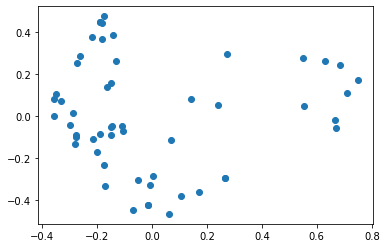

In [27]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(sentence_embeddings)
explained_variance = pca.explained_variance_ratio_
print("Explained variance = ",sum(explained_variance))
plt.scatter(x = x_pca.T[0], y=x_pca.T[1])
plt.show()

In [13]:
# clustering
from sklearn.cluster import SpectralClustering, AffinityPropagation

In [28]:
# use algorithms to reduce demension

pca = PCA()
sentence_embeddings_distilled = pca.fit_transform(sentence_embeddings)

In [41]:
cluster_algo = AffinityPropagation(random_state=43)
# cluster_algo = SpectralClustering(random_state=43, n_clusters=18)
# cluster = cluster_algo.fit(sentence_embeddings)
cluster = cluster_algo.fit(sentence_embeddings_distilled)
print("Clustered into {} clusters with labels {}".format(
    np.unique(cluster.labels_).shape, np.unique(cluster.labels_)))


Clustered into (13,) clusters with labels [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


In [42]:
unique, count = np.unique(cluster.labels_, return_counts=True)
print(dict(zip(*np.unique(cluster.labels_, return_counts=True))))


{0: 2, 1: 5, 2: 2, 3: 2, 4: 1, 5: 2, 6: 1, 7: 1, 8: 11, 9: 4, 10: 3, 11: 11, 12: 9}


In [43]:
center_claims = {i: [] for i in range(len(np.unique(cluster.labels_)))}
for i,label in enumerate(cluster.labels_):
    center_claims[label].append(claims[i])
center_claims

{0: ['A “bubble” occurs when the price of a stock or investment is driven up to unsustainably high levels, substantially way more than what that item is worth. This bubble is usually caused by emotions of the masses, and not by logical investing or “looking at fundamentals”. And it always starts off as something that made sense in the beginning.\n\nIts exactly the same with Bitcoin.',
  'It is almost certainly in a bubble.'],
 1: ['Bitcoin is extremely weird',
  'Bitcoins Are Scarce',
  'Bitcoins Are Useful',
  'Bitcoin is pretty useless. But so is gold.',
  'Bitcoin is pretty useless. But so is gold.'],
 2: ['', 'No,'],
 3: ['I would say YES!', 'The simple answer is Yes.'],
 4: ['That’s up to you.'],
 5: ['It depends what your level of disposable income is, how great your assets are, and what other assets you have invested in.',
  'It depends what your level of disposable income is, how great your assets are, and what other assets you have invested in.'],
 6: ['Cryto currency is an ex

In [45]:
for i,term in enumerate(cluster.cluster_centers_indices_):
    print(f"{i}:\t{claims[term]}")

0:	A “bubble” occurs when the price of a stock or investment is driven up to unsustainably high levels, substantially way more than what that item is worth. This bubble is usually caused by emotions of the masses, and not by logical investing or “looking at fundamentals”. And it always starts off as something that made sense in the beginning.

Its exactly the same with Bitcoin.
1:	Bitcoin is pretty useless. But so is gold.
2:	
3:	I would say YES!
4:	That’s up to you.
5:	It depends what your level of disposable income is, how great your assets are, and what other assets you have invested in.
6:	Cryto currency is an extremely high-hazard venture, and CFDs bought on margin are significantly more hazardous.
7:	The significant thing is to do your own research and comprehend the dangers.
8:	Invest in Bitcoin, only if you are okay to loss all.
9:	it’s not too late to invest.
10:	Of course you should
11:	Investing in Bitcoin is viable option especially in a view of current decline of the power